# Import Libraries

In [3]:
import pandas as pd
import numpy as np

import nltk

import itertools

from sentence_level_preprocess import *
from word_level_preprocess import *
from indexation import *
from featurize import *
from embeddings import Embeddings

from typing import Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from scipy.stats import uniform

import seaborn as sns

In [4]:
numpy_records = List[Tuple]

def load_data(path: str) -> numpy_records:
    df = pd.read_csv(path, sep='\t')
    return df.to_records(index=False)

def preprocess(data: numpy_records) -> numpy_records:
    # remove line breaks (e.g. "elec- tron" -> "electron")
    data = [(rm_linebreaks(t), l) for t, l in data]

    # lower case
    data = [(t.lower(), l) for t, l in data]

    # unify expressions for temperature (e.g. '° c' -> '<temp>')
    data = [(c2temp_2(t), l) for t, l in data]

    data = [(nltk.tokenize.word_tokenize(t), l) for t, l in data]

    # recognize integer as '<int>' (e.g. '60' -> '<int>')
    data = [([put_int_together(w) for w in t], l) for t, l in data]

    # recognize decimal as '<dec>' (e.g. '0.5' -> '<dec>')
    data = [([put_decimal_together(w) for w in t], l) for t, l in data]

    # recognize ratioas '<ratio>' (e.g. '1:1' -> '<ratio>')
    data = [([put_ratio_together(w) for w in t], l) for t, l in data]

    # split slash (e.g. 'g/mol' -> '['g', '/', 'mol'])
    data = [([split_slash(w) for w in t], l) for t, l in data]
    data = [(list(itertools.chain.from_iterable(t)), l) for t, l in data] # flatten

    # unify expressions for temperature (e.g. '°c' -> '<temp>')
    data = [([c2temp(w) for w in t], l) for t, l in data]
    
    return data

def index_words(data: numpy_records):
    texts   = [x[0] for x in data]
    targets = [[x[1]] for x in data]
    texts, vocab_size, _   = word2idx(texts)
    targets, _, _          = word2idx(targets)
    targets = [l[0] for l in targets]
    data_idx = list(zip(texts, targets))
    return (data_idx, vocab_size, targets)

def BOW_featurize(data_idx, vocab_size):
    return [(bow(t, vocab_size), l) for t, l in data_idx]

# def train_val_split(data: numpy_records) -> Tuple[List[str]]:
#     X = [t for t, _ in data]
#     y = [l for _, l in data]
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
#     return (X_train, X_val, y_train, y_val)

def embed_one_set(embedding, X):
    return embedding.transform(X.text.apply(lambda x: ' '.join([str(y) for y in x])))

def embed(embedding, train_data, val_data):
    return (embed_one_set(embedding, train_data), embed_one_set(embedding, val_data))

def generate_embeddings(path: str, embed):
    data_idx, vocab_size, targets = index_words(preprocess(load_data(path)))
    X_total = pd.DataFrame(data_idx, columns=['text', 'classification'])
    y_total = X_total.pop('classification')
    X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, test_size=0.2)
    embeddings = Embeddings(X_train, X_val)
    X_train, X_val = embed(embed, X_train, X_val)
    return (X_train, X_val, y_train, y_val)

def do_all_preprocess(path: str) -> Tuple[pd.DataFrame]:
    data_idx, vocab_size, targets = index_words(preprocess(load_data(path)))
    X_total = pd.DataFrame(data_idx, columns=['text', 'classification'])
    y_total = X_total.pop('classification')
    return (X_total, y_total)

def generate_split(path: str):
    X_total, y_total = do_all_preprocess(path)
    X_train, X_val, y_train, y_val = train_test_split(X_total, y_total, test_size=0.2)
    return (X_train, X_val, y_train, y_val)

def find_avg_performance(test_model: BaseEstimator, embedding_type, num_trial = 20) -> None:
    f1s = []

    for i in range(num_trial):
        X_train_avg, X_val_avg, y_train_avg, y_val_avg = generate_split('../data/train.tsv')
        X_train_avg, X_val_avg = embed(embedding_type, X_train_avg, X_val_avg)
        test_model.fit(X_train_avg, y_train_avg)
        y_pred = test_model.predict(X_val_avg)
        f1 = f1_score(y_val_avg, y_pred, average='micro')
        f1s.append(f1)

    print("mean:", np.mean(f1s))
    print("std :", np.std(f1s))

def to_scaled_embeds(X_train, X_val, embed_type, dense=True):
    X_train, X_val = embed(embed_type, X_train, X_val)
    if dense:
        X_train = X_train.todense()
        X_val = X_val.todense()
    X_train = StandardScaler().fit_transform(X_train)
    X_val = StandardScaler().fit_transform(X_val)
    return (X_train, X_val)

def scale_embed(X, embed_type, dense=True):
    X = embed_one_set(embed_type, X)
    if dense:
        X = X.todense()
    X = StandardScaler().fit_transform(X)
    return X

def find_test_performance(model, embed_type, dense=True):
    X_test, y_test = do_all_preprocess('../data/test.tsv')
    X_test = scale_embed(X_test, embed_type, dense)
    preds = model.predict(X_test)
    sns.heatmap(confusion_matrix(y_test, preds), annot=True)
    return f1_score(y_test, preds, average='micro')


In [125]:
X_train, X_val, y_train, y_val = generate_split('../data/train.tsv')

total_train = do_all_preprocess('../data/train.tsv')
total_test = do_all_preprocess('../data/test.tsv')
embeddings = Embeddings(total_train[0].text, total_test[0].text)

### BOW Data

Uncomment **one** of these three cells to experiment with that type of word-representation.

In [126]:
embed_type = embeddings.BOW()
X_train, X_val = to_scaled_embeds(X_train, X_val, embed_type, dense=True)

/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/referenc

### TF-IDF Data

In [120]:
# embed_type = embeddings.TFIDF()
# X_train, X_val = to_scaled_embeds(X_train, X_val, embed_type, dense=True)

### word2vec Data

In [121]:
# embed_type = embeddings.word2vec()
# X_train, X_val = to_scaled_embeds(X_train, X_val, embed_type, dense=False)

# Learn Classifiers

## Logistic regression

In [139]:
lr_model = LogisticRegression(penalty='l2', max_iter=5000)
lr_model.fit(X_train, y_train)

f1_score(y_train, lr_model.predict(X_train), average='micro')

/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.995850622406639

### Confusion matrix

In [129]:
y_pred = lr_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

<AxesSubplot:>

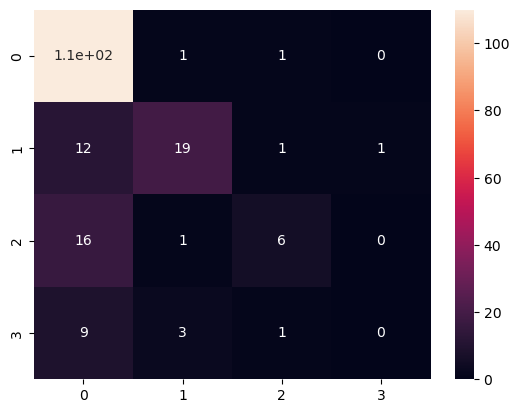

In [130]:
sns.heatmap(cm, annot=True)

<AxesSubplot:>

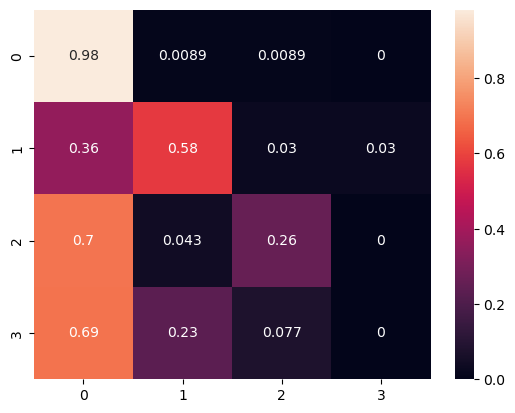

In [131]:
sns.heatmap(cm / np.tile(np.sum(cm, axis=1), (4, 1)).T, annot=True)

### Average performance

In [132]:
find_avg_performance(LogisticRegression(max_iter=10000), embed_type)

mean: 0.8403314917127072
std : 0.028542743321744703


/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.5726872246696035

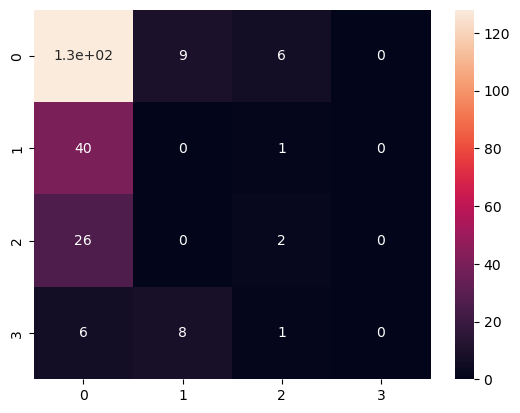

In [133]:
find_test_performance(lr_model, embed_type, True)

### Hyperparameter Tuning

In [134]:
param_grid_lr = {
    'C': uniform(0.001, 1000),
     'class_weight': [None, 'balanced']
}

lr2_grid = RandomizedSearchCV(
    LogisticRegression(max_iter=30000), 
    param_distributions=param_grid_lr, 
    n_jobs=-1, 
    scoring='f1_micro'
)
lr2_grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=30000), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f69bbdf1d00>,
                                        'class_weight': [None, 'balanced']},
                   scoring='f1_micro')

In [136]:
find_avg_performance(lr2_grid, embed_type)

KeyboardInterrupt: 

<AxesSubplot:>

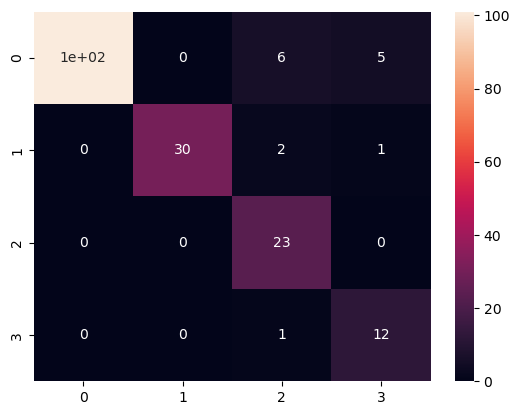

In [137]:
y_pred = lr2_grid.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True)

/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/ldtcoop/miniconda3/envs/pollydarton/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.33480176211453744

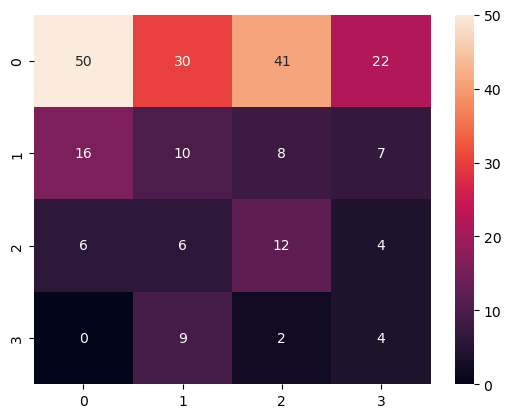

In [138]:
find_test_performance(lr2_grid, embed_type, True)

## SVM

In [81]:
from sklearn.svm import SVC, LinearSVC

def get_kernel(model) -> str:
    params = model.get_params()
    return model.get_params()['kernel'] if ('kernel' in params) else 'linear'

def evaluate_svm(model, X, y):
    y_pred_train = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True)
    kernel = get_kernel(model)
    print(f'F1 Score (test, {kernel}): {model.score(X, y)}')

def train_svm(model, X, y):
    model.fit(X, y)
    print(f'F1 Score (train, {get_kernel(model)}): {model.score(X, y)}')

def tune_svm(model, grid, X, y): 
    model_grid = RandomizedSearchCV(model, grid, refit=True, n_jobs=-1, scoring='f1_micro')
    model_grid.fit(X_train, y_train)
    print(f'F1 Score (train, {get_kernel(model)}): {model_grid.score(X, y)}')
    return model_grid

In [82]:
lin_svm = LinearSVC(max_iter=10000)
poly_svm = SVC(kernel='poly', cache_size=500)
rbf_svm = SVC(kernel='rbf', cache_size=500)
sigmoid_svm = SVC(kernel='sigmoid', cache_size=500)

train_svm(rbf_svm, X_train, y_train)
train_svm(sigmoid_svm, X_train, y_train)

F1 Score (train, rbf): 0.9820193637621023
F1 Score (train, sigmoid): 0.9225449515905948


In [83]:
from scipy.stats import randint, uniform

poly_grid = {
    'C': uniform(1e-4, 1e4),
    'degree': [3,4,5,6,7,8],
    'gamma': uniform(1e-5, 1),
    'coef0': uniform(0,1),
    'class_weight': [None, 'balanced']
}

rbf_grid = {
    'C': uniform(1e-4, 1e4),
    'gamma': uniform(1e-5, 1),
    'class_weight': [None, 'balanced']
}

tuned_rbf = tune_svm(rbf_svm, rbf_grid, X_train, y_train)
tuned_sig = tune_svm(sigmoid_svm, poly_grid, X_train, y_train)


F1 Score (train, rbf): 0.9930843706777317
F1 Score (train, sigmoid): 0.9944674965421854


In [84]:
print('RBF SVM')
find_avg_performance(tuned_rbf.best_estimator_, embed_type)

print('Sigmoid SVM')
find_avg_performance(tuned_sig.best_estimator_, embed_type)

RBF SVM
mean: 0.8370165745856353
std : 0.02430311320212459
Sigmoid SVM
mean: 0.8314917127071825
std : 0.026293931567493458


## Neural Net

In [5]:
from neural_network import RNN, NNTrainer
import torch
import torch.utils.data

import os

import neural_network
import DataLoader
import indexation
import Tokenizer

In [8]:
main_dir = os.path.dirname('./')
train_path = os.path.join(main_dir, '../data/new_train.tsv')
test_path = os.path.join(main_dir, '../data/new_test.tsv')
train = pd.read_csv(train_path, sep='\t')
test = pd.read_csv(test_path, sep='\t')

# preprocessing
train = pd.DataFrame(preprocess(train.to_records(index=False)), columns=train.columns)
test = pd.DataFrame(preprocess(test.to_records(index=False)), columns=test.columns)

# tokenize
train.text = train.text.str.join(' ').apply(Tokenizer.tokenize_text)
test.text = test.text.str.join(' ').apply(Tokenizer.tokenize_text)

# continue script
words, num_words, word_types = indexation.word2idx(list(pd.concat([train, test]).text))
train_words = words[:len(train)]
test_words = words[len(train):]
train['idx'] = train_words
test['idx'] = test_words
max_len = max([len(word) for word in words])
# print(max_len) <--- change to use python logging
train_set = DataLoader.TextDataset(train, max_len, num_words)
test_set = DataLoader.TextDataset(test, max_len, num_words)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)
nn_embed = neural_network.RNN(4, 50, num_words, 100, False, word_types)
nn_w2v = neural_network.RNN(4, 50, num_words, 100, False, word_types)
nn_w2v.set_embedding_weights()
nn_trainer_e = neural_network.NNTrainer(
    nn_embed,
    5,
    torch.optim.Adam,
    torch.nn.CrossEntropyLoss(),
    train_loader,
    test_loader
)
nn_trainer_w = neural_network.NNTrainer(
    nn_embed,
    5,
    torch.optim.Adam,
    torch.nn.CrossEntropyLoss(),
    train_loader,
    test_loader
)

In [10]:
train

,text,label,idx
0,"[the, mixture, was, stirred, overnight, .]",action,"[2, 42, 11, 116, 262, 5]"
1,"[sd, and, swf, were, milled, through, an, 80-m...",action,"[2387, 9, 3744, 12, 2388, 157, 29, 6603, 6604,..."
2,"[prior, to, each, experiment, ,, a, suspension...",action,"[221, 14, 86, 398, 3, 10, 148, 8, 2, 496, 497,..."
3,"[finally, ,, a, thin, layer, of, nafion, was, ...",action,"[399, 3, 10, 263, 231, 8, 2389, 11, 370, 28, 2..."
4,"[for, the, preparation, of, the, epoxy−clay, c...",action,"[16, 2, 117, 8, 2, 1364, 54, 62, 438, 3, 2, 66..."
...,...,...,...
6403,"[pp, homopolymer, (, pd, <, int, >, ,, melt, i...",property,"[624, 2194, 6, 4498, 0, 4, 1, 3, 759, 726, 0, ..."
6404,"[the, gpc, measurement, showed, that, p, (, vd...",property,"[2, 615, 282, 1671, 55, 346, 6, 6507, 11745, 7..."
6405,"[due, to, their, large, aspect, ratio, and, un...",property,"[480, 14, 449, 738, 1275, 68, 9, 4627, 1434, 3..."
6406,"[the, nanosize, ba0.5sr0.5tio3, powder, (, sig...",property,"[2, 11746, 11747, 182, 6, 6508, 1703, 2095, 3,..."


In [9]:
nn_trainer_e.fit(train.idx, train.label)

NameError: name 'X_train' is not defined